In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import numpy as np
import seaborn as sns
import sys
sys.path.append('../notebooks_llm/')
plt.style.use('default')
dvu.set_style()
UNKS = {"Unk", "-", -1, "-1"}
df = pd.read_pickle('../data/data_clean.pkl')

idxs = (df["participants___male"].notnull() & ~(df["participants___male"].isin(UNKS))) & (
    df["participants___female"].notnull() & ~(df["participants___female"].isin(UNKS))
)
male = df["participants___male"][idxs].astype(int)
female = df["participants___female"][idxs].astype(int)
frac_male = male / (male + female)
frac_female = female / (male + female)
ratios = (male / female).values

### Main figure

mean frac_male 54.69 mean_frac_male_weighted 53.5681509348908 perc skewed 0.647


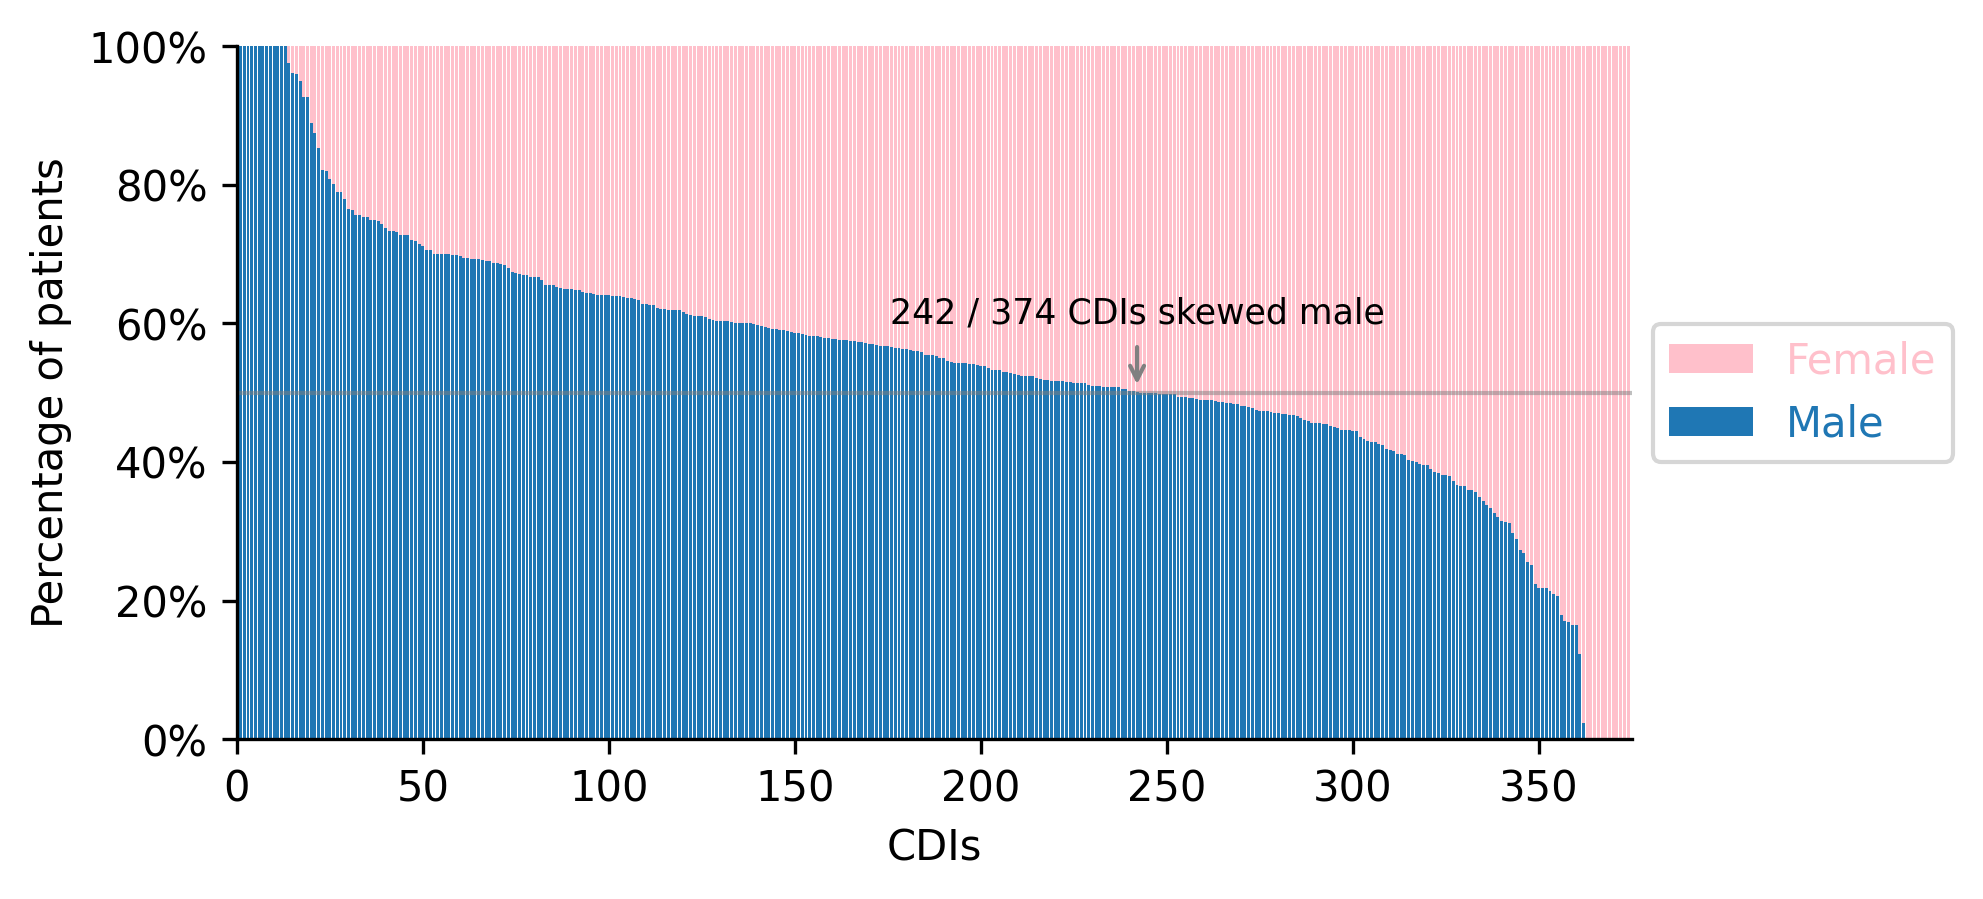

In [2]:
args = np.argsort(frac_male)[::-1]
frac_male = frac_male.values[args] * 100
frac_female = frac_female.values[args] * 100

# barplot showing frac_male and frac_female as stacked bars
plt.figure(figsize=(6, 3), dpi=300)

num_cdis = len(frac_male)
bar_positions = np.arange(num_cdis) + 1
plt.bar(bar_positions, frac_female, bottom=frac_male, label="Female", color="pink")
plt.bar(bar_positions, frac_male, label="Male", color="C0")
plt.axhline(50, color="gray", alpha=0.5, lw=1)

plt.xlabel("CDIs")
plt.ylabel("Percentage of patients")
# place legend to the right of the plot
plt.legend(labelcolor="linecolor", loc="center left", bbox_to_anchor=(1, 0.5))
# plt.xticks(np.arange(1, num_cdis + 1, num_cdis//3), np.arange(1, num_cdis + 1, num_cdis//3))
plt.xlim(left=0, right=num_cdis + 1)
plt.yticks(np.arange(0, 101, 20), [f"{t}%" for t in np.arange(0, 101, 20)])

# annotate the point where the two bars cross 50 percent
x_cross = np.where(frac_male <= frac_female)[0][0]
plt.annotate(
    f"{x_cross} / {num_cdis} CDIs skewed male",
    (x_cross, 50),
    xytext=(x_cross, 60),
    ha="center",
    arrowprops=dict(arrowstyle="->", color="gray"),
    fontsize="small",
)
print(
    "mean frac_male",
    np.mean(frac_male).round(2),
    'mean_frac_male_weighted',
    np.average(frac_male, weights=male + female),
    "perc skewed",
    round(np.sum(frac_male > frac_female) / len(frac_male), 3),
)

# Show the plot
plt.show()

### Sex-specific table

In [3]:
# df[idxs][male == 0].head(20)
d = df[idxs][(male == 0) | (female == 0)][
    [
        "title",
        "description_short",
        "paper___citation",
        "participants___male",
        "participants___female",
    ]
].sort_values(by='participants___male', ascending=False)
d.to_csv("../results/sex_specific_cdis.csv", index=False)
# with pd.option_context("display.max_colwidth", None):
    # display(d.style.format(precision=0))

### Stratified table

In [14]:

for cat in ['categorization___specialty', 'categorization___disease', 'categorization___system']:
    COUNT_THRESH = 5
    d = df[idxs]
    d["frac_male"] = df["participants___male"] / (
        df["participants___male"] + df["participants___female"]
    )
    d = d.explode(cat)[[cat, "frac_male"]]
    d = d[d[cat].notnull()]
    val_counts = d[cat].value_counts()
    d = d[d[cat].apply(lambda x: val_counts[x] >= COUNT_THRESH)]
    fracs = d.groupby(cat).mean().reset_index()
    fracs = fracs.sort_values(by="frac_male")
    cat_name = cat.split("___")[1].capitalize()
    fracs.to_csv(f'../results/sex_breakdown_{cat_name}.csv', index=False, float_format='%.3f')


    # plt.figure(figsize=(5, 10), dpi=200)
    # sns.barplot(y=cat, x="frac_male", data=fracs, color="mediumseagreen")
    # plt.axvline(0.5, color="gray")
    # # set yticks fontsize to small
    # plt.yticks(fontsize="xx-small")
    # plt.ylabel(cat_name)
    # plt.xlabel("Fraction of patients identified as male")
    # plt.show()

/tmp/ipykernel_211805/3033545849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["frac_male"] = df["participants___male"] / (
/tmp/ipykernel_211805/3033545849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["frac_male"] = df["participants___male"] / (
/tmp/ipykernel_211805/3033545849.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [18]:
# plt.figure(figsize=(4, 2), dpi=300)
# r = ratios[~np.isinf(ratios)]
# r = r[r > 0]
# logr = np.log10(r)
# print(
#     "mean",
#     r.mean().round(2),
#     'median',
#     np.median(r).round(2),
#     "frac>0",
#     (r > 1).sum(),
#     "/",
#     len(r),
#     "excluding",
#     np.sum(np.isinf(ratios)),
#     "all-male studies and",
#     np.sum(ratios == 0),
#     "all-female studies",
# )
# plt.hist(logr[logr < 0], color="pink")  # , bins=100)
# plt.hist(logr[logr >= 0], color="C0")  # , bins=100)
# plt.axvline(0, color="black", ls="--")
# ticks = plt.xticks()[0]
# plt.xticks(ticks, [f"$10^{{{t}}}$" for t in ticks])
# plt.xlabel("Ratio (male / female)")
# plt.ylabel("Count")
# plt.show()

In [ ]:
# VIOLIN PLOT ##

# frac_male = frac_male = df['frac_male'][idxs & (df['num_male_corrected'] >= 1) & (df['num_female_corrected'] >= 1)]
# frac_female = 1 - frac_male

# dd = pd.DataFrame.from_dict(
#     {
#         "frac": frac_male.tolist() + frac_female.tolist(),
#         "sex": [0] * len(frac_male) + [1] * len(frac_female),
#     }
# )
# sns.violinplot(dd, x="sex", y="frac", palette=["C0", "pink"], cut=0, bw=0.3)